In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import sklearn

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 166691 × 19309
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
pdf = adata.copy()

data = [
    'pellin',
    'iHSC',
    'young2_HSC',
    'tabula_sapiens',
]

mask = pdf.obs['dataset'].isin(data)
pdf = pdf[mask, :]

# drop HSC from tabula
mask = (pdf.obs['celltype'] == 'HSC') & (pdf.obs['dataset'] == 'tabula_sapiens')
pdf = pdf[~mask, :]

# # drop lin- cells from pellin
# mask = (pdf.obs['cell_type'].str.contains('LinNeg')) & (pdf.obs['dataset'] == 'pellin')
# pdf = pdf[~mask, :]


keep_cols = [
    'n_genes',
    'cell_type',
    'dataset',
    'organ_tissue',
    'compartment',
]

pdf.obs = pdf.obs[keep_cols]

sc.pp.filter_genes(pdf, min_counts=3)
sc.pp.filter_cells(pdf, min_counts=100)

sc.pp.normalize_total(pdf)
sc.pp.log1p(pdf)

sc.pp.combat(pdf, key='dataset')

# handle negatives
pdf.X = np.where(pdf.X < 0, 0, pdf.X)

sc.pp.highly_variable_genes(pdf)


pdf

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


AnnData object with n_obs × n_vars = 60263 × 19114
    obs: 'n_genes', 'cell_type', 'dataset', 'organ_tissue', 'compartment', 'n_counts'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [4]:
pdf.obs['dataset'].value_counts()

dataset
tabula_sapiens    26586
pellin            21412
iHSC               8562
young2_HSC         3703
Name: count, dtype: int64

In [5]:
pdf.obs['cell_type'].value_counts()

cell_type
FB                        26586
iHSC                       8562
LinNegCD34PosCD164Pos      6343
HSC                        4525
LinNegCD34NegCD164high     4434
LinNegCD34lowCD164high     4266
CMP                        1576
MEP                        1211
GMP                        1012
MPP                         611
PreBNK                      592
LinNegCD34NegCD164low       358
MLP                         123
MKP                          64
Name: count, dtype: int64

In [6]:
sc.tl.pca(pdf, svd_solver="arpack")
sc.pp.neighbors(pdf)
sc.tl.umap(pdf, min_dist=0.8, spread=2.0)

print('done')

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done


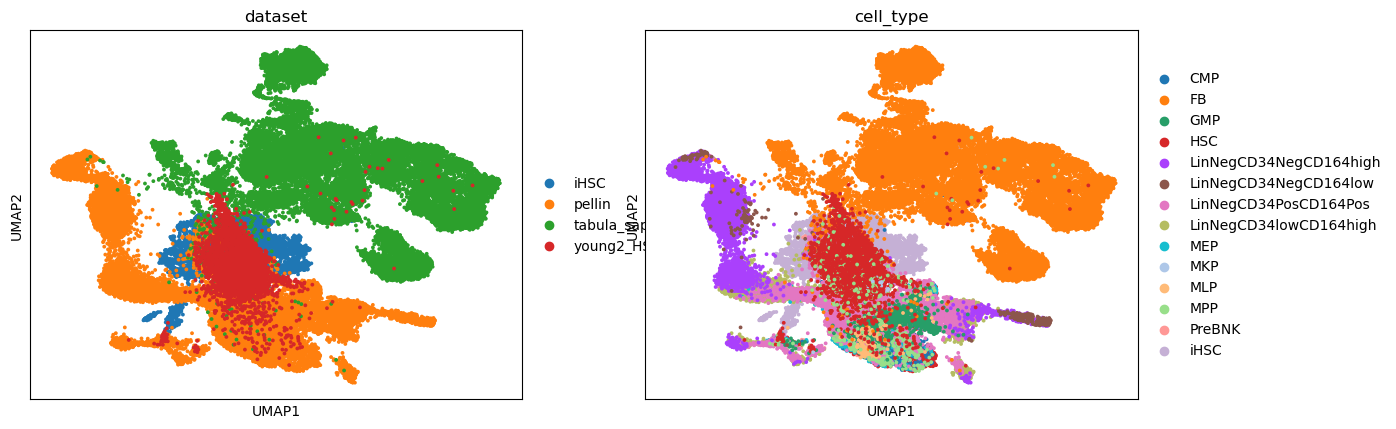

In [7]:
sc.pl.umap(pdf, 
           color=['dataset','cell_type'],
           s=30,)

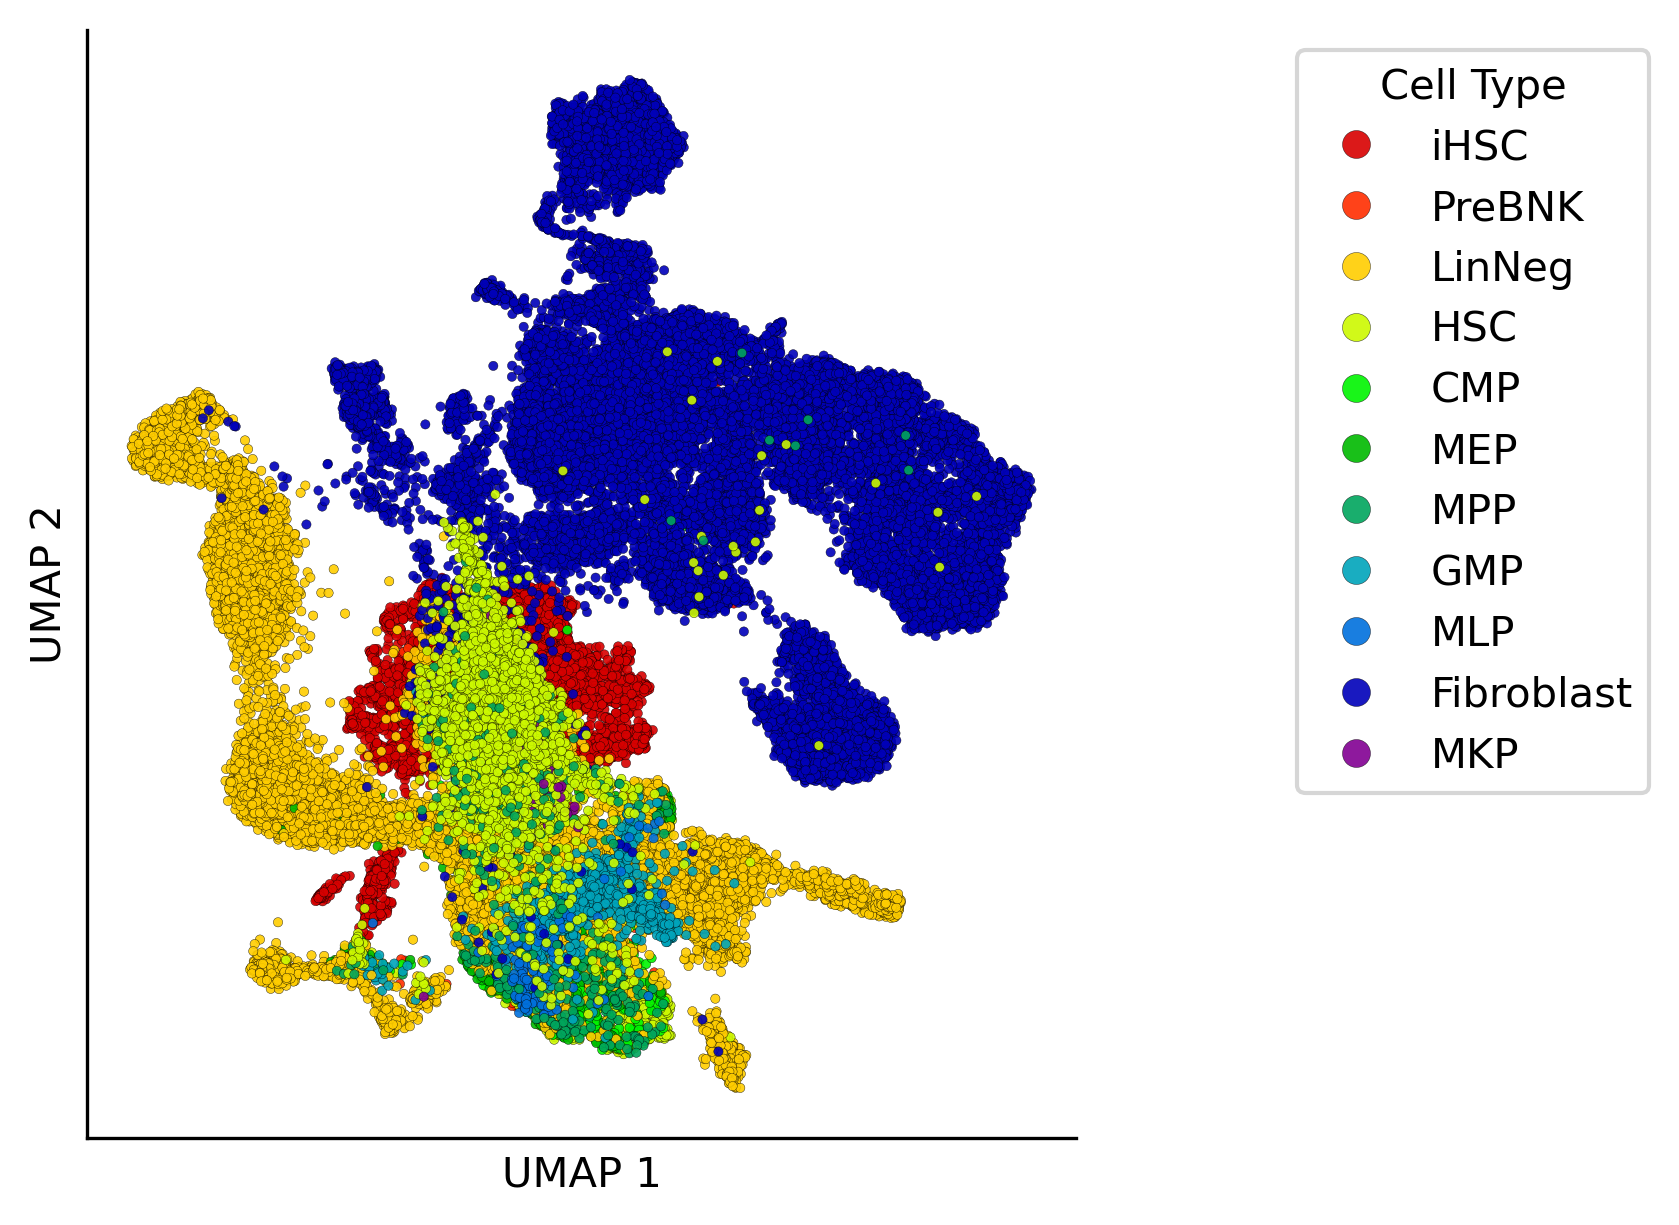

In [8]:
pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

cell_map = {
    'iHSC' : 'iHSC',
    'PreBNK' : 'PreBNK',
    'LinNegCD34lowCD164high' : 'LinNeg',
    'HSC' : 'HSC',
    'CMP' : 'CMP',
    'MEP' : 'MEP',
    'LinNegCD34PosCD164Pos' : 'LinNeg',
    'LinNegCD34NegCD164high' : 'LinNeg',
    'MPP' : "MPP",
    'GMP' : "GMP",
    'LinNegCD34NegCD164low' : 'LinNeg',
    'MLP' : "MLP",
    'FB' : "Fibroblast",
    'MKP' : "MKP"
}

pdf.obs['broad_type'] = pdf.obs['cell_type'].map(cell_map)


plt.rcParams['figure.dpi'] = 300

sns.scatterplot(data=pdf.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                lw=0.1,
                alpha=0.9,
                hue='broad_type',
                palette="nipy_spectral_r",
                s=5)


plt.xticks([])
plt.yticks([])
sns.despine()


sns.move_legend(plt.gca(), 
                title="Cell Type",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.6, 1))
plt.gca().set_aspect('equal')

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 300

sns.scatterplot(data=pdf.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='None',
                zorder=0,
                color='lightgrey',
                s=5)


mask = pdf.obs['cell_type'] == "iHSC"
sns.scatterplot(data=pdf.obs[mask],
                x='UMAP 1',
                y='UMAP 2',
                ec='None',
                zorder=2,
                color='r',
                s=5)

plt.xticks([])
plt.yticks([])
sns.despine()
plt.gca().set_aspect('equal')

In [ ]:
pdf.obs.head()

In [ ]:
metric = 'cosine'

our = pdf.obs[pdf.obs['broad_type'] == 'iHSC'].copy()

columns = ['UMAP 1', 'UMAP 2']
X = our[columns].to_numpy()

print(f"{cells.shape=}")

medians = pdf.obs.groupby('broad_type').agg(
    UMAP1 = ('UMAP 1', 'median'),
    UMAP2 = ('UMAP 2', 'median'),
).reset_index()

cell_types = []

for idx, row in medians.iterrows():
    cell_types.append(row['broad_type'])
    Y = row[['UMAP1', 'UMAP2']].to_numpy().reshape(1, -1)
    d = sklearn.metrics.pairwise_distances(X, Y, metric=scipy.spatial.distance.euclidean)
    our[row['broad_type']] = np.ravel(d)


our.head()

In [ ]:
plot = our.copy().reset_index()
plot = pd.melt(plot, id_vars='index',
               value_vars=cell_types)

include = [
    'Fibroblast',
    'HSC',
]

mask = plot['variable'].isin(include)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3
sns.histplot(data=plot[mask],
             x='value',
             hue='variable',
             kde=True)

plt.xlabel(f"{metric.title()} Distance")

sns.move_legend(plt.gca(), 
                title="Distance to:",
                loc='best')

sns.despine()

In [ ]:
plot = our.copy().reset_index()

sns.scatterplot(data=our,
                x='HSC',
                y='Fibroblast')

In [ ]:
plot['variable'].unique()

In [ ]:
def plot_umap_scatter(
    adata, x= "UMAP 1", 
    y="UMAP 2", color="CD34", 
    cmap="viridis",
    vmin=None,
    vmax=None,
    **kwargs
) -> plt.Axes:
    """
    Creates a scatterplot of UMAP data from an AnnData object with color mapping and a colorbar.

    Args:
        adata (anndata.AnnData): The AnnData object containing the UMAP embedding and color data.
        x (str, optional): Column name in `adata.obsm` for x-coordinates (default: "UMAP 1").
        y (str, optional): Column name in `adata.obsm` for y-coordinates (default: "UMAP 2").
        color (str, optional): Column name in `adata.var` or `adata.obs` for color mapping (default: "CD34").
        cmap (str or matplotlib.colors.Colormap, optional): Colormap to use (default: "viridis").
        vmin (float, optional): Minimum value for colormap normalization (default: None).
        vmax (float, optional): Maximum value for colormap normalization (default: None).
        **kwargs: Additional keyword arguments passed to `plt.scatter`.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the plot.

    Raises:
        KeyError: If `color` is not found in `adata.var` or `adata.obs`.
    """

    if color in adata.var_names:  # Color is a gene expression value
        df = adata.to_df()
        df.columns = adata.var['gene_name'].values  # Use gene names as column labels
        expression = df[color].values  
    elif color in adata.obs:
        expression = adata.obs[color].values
    else:
        raise KeyError(f"Color key '{color}' not found in adata.var or adata.obs")

    # Sort points for smooth colorbar
    order = np.argsort(expression)

    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(expression)
    if vmax is None:
        vmax = np.max(expression)

    # Create scatterplot with normalized colormap
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        adata.obs[x].iloc[order],
        adata.obs[y].iloc[order],
        c=expression[order],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        **kwargs
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, shrink=0.4, ax=ax)

    # Additional formatting
    sns.despine(ax=ax)
    ax.set(
        title=color,
        xlabel=x,
        ylabel=y,
        xticks=[],
        yticks=[]
    )

    return ax

plot_umap_scatter(pdf, s=3)

In [ ]:
plot_umap_scatter(pdf, color='GATA2', vmin=0, vmax=4, s=3)

In [ ]:
plot_umap_scatter(pdf, color='HLF', vmin=0, vmax=3, s=3)

# Pseudotime

In [ ]:
mask = (pdf.obs['cell_type'] != 'FB')
hdf = pdf[mask, :].copy()

sc.pp.combat(hdf, key='dataset')

# handle negatives
hdf.X = np.where(hdf.X < 0, 0, hdf.X)

# reprocess
sc.pp.highly_variable_genes(hdf, n_top_genes=2000)

sc.tl.pca(hdf)
sc.pp.neighbors(hdf)
sc.tl.umap(hdf) 

hdf

In [ ]:
sc.pl.umap(hdf,
           color=['cell_type', 'dataset'],
           s=50)

In [ ]:
root_type = "HSC"
hdf.uns['iroot'] = np.flatnonzero(hdf.obs['cell_type'] == root_type)[0]

sc.tl.diffmap(hdf, n_comps=21)
sc.pp.neighbors(hdf, n_neighbors=7)
sc.tl.dpt(hdf, n_branchings=0)

hdf

In [ ]:
sc.pl.umap(hdf,
           color='dpt_pseudotime',
           vmin=0, 
           vmax=0.5,
           s=50)

In [ ]:
break

In [ ]:
break